In [1]:
from __future__ import print_function
from __future__ import division
import keras
import os
import time
from keras.models import Sequential, Model
from keras import layers
from keras import backend as K
from keras import optimizers
from keras.layers import Activation, Dense, Merge
from keras.constraints import Constraint

Using TensorFlow backend.


In [0]:
from math import *
import numpy as np
%matplotlib inline
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.integrate as integrate
import scipy.stats as st
from keras.constraints import max_norm
#from pylab import *


In [3]:
print(keras.__version__)

2.1.6


In [4]:
!python -V

Python 3.6.3


In [3]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [0]:
matplotlib.rc_params()

In [0]:
!cat /proc/cpuinfo

In [0]:
!cat /proc/meminfo

In [0]:
#!apt-get -qq install -y graphviz && pip install -q pydot
#import pydot

## Connect to Google Drive for storage 

### Pydrive

In [0]:
# install PyDrive
!pip install -U -q PyDrive

In [4]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# PyDrive reference:
# https://googledrive.github.io/PyDrive/docs/build/html/index.html

'''
# 2. Create & upload a file 
uploaded = drive.CreateFile({'title': 'Sample upload.txt'})
uploaded.SetContentString('Sample upload file content')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

# 3. Load a file by ID and print its contents.
downloaded = drive.CreateFile({'id': uploaded.get('id')})
print('Downloaded content "{}"'.format(downloaded.GetContentString()))
'''

'\n# 2. Create & upload a file \nuploaded = drive.CreateFile({\'title\': \'Sample upload.txt\'})\nuploaded.SetContentString(\'Sample upload file content\')\nuploaded.Upload()\nprint(\'Uploaded file with ID {}\'.format(uploaded.get(\'id\')))\n\n# 3. Load a file by ID and print its contents.\ndownloaded = drive.CreateFile({\'id\': uploaded.get(\'id\')})\nprint(\'Downloaded content "{}"\'.format(downloaded.GetContentString()))\n'

In [0]:
def upload_file_to_specific_folder(folder_id, file_name):
    file_metadata = {'title': file_name, "parents": [{"id": folder_id, "kind": "drive#childList"}]}
    folder = drive.CreateFile(file_metadata)
    folder.SetContentFile(file_name) #The contents of the file
    folder.Upload()

In [0]:
# Auto-iterate through all files that matches this query
#NNRatioData: 1iYZSLhjTVMwaX3PVK5dzJdywjpqsDS1Z
file_list = drive.ListFile({'q': "'1SH8q5-SqxKrpBax48m8HImqqlHSHSVfN' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))


In [0]:
#Download to colab
# Load a file by ID and print its contents.
for file1 in file_list:
  downloaded = drive.CreateFile({'id':file1['id']})
  downloaded.GetContentFile(file1['title'])
#print('Downloaded content "{}"'.format(downloaded.GetContentString()))

In [6]:
print(os.getcwd())
print(os.listdir('/content'))

/content
['datalab', '.cache', '.ipython', '.forever', '.config', '.keras', '.local']


# Main

In [0]:
#sigmoid function
def sigmoid(x):
  return 1 / (1 + exp(-x))

### weight-clipping


In [0]:
class WeightClip(Constraint):
    '''Clips the weights incident to each hidden unit to be inside a range
    '''
    def __init__(self, c=2):
        self.c = c

    def __call__(self, p):
        return K.clip(p, -self.c, self.c)

    def get_config(self):
        return {'name': self.__class__.__name__,
                'c': self.c}

In [0]:
#@title Glabal Parameters
epochs = 100000 #@param {type:"integer"}
batch_size = 1000 #@param {type:"integer"}
Geteps = 0.005 #@param {type:"number"}
Getmu = 0.8 #@param {type:"number"}
Getsigma = 0.02 #@param {type:"number"}
cut = 0. #@param {type:"number"}
gcut = 0. #@param {type:"number"}


In [0]:
'''Distribution functions'''
def SM(x):
  return exp(-8*x)

def BSM(x):
  return exp(-(x-Getmu)**2/(2*Getsigma**2))
#Normalize distribution
SM_norm = integrate.quad(lambda y :SM(y),cut,1)
BSM_norm = integrate.quad(lambda y :BSM(y),cut,1)
#SM_norm_c = integrate.quad(lambda y :SMn(y),gcut,1)

#normalized distribution
def SMn(x):
  return exp(-8*x)/SM_norm[0]

def BSMn(x):
  return (SMn(x)+Geteps*BSM(x)/BSM_norm[0])/(1+Geteps)

SM_norm_c = integrate.quad(lambda y :SM(y),gcut,1)

def SMnc(x):
  return exp(-8*x)/SM_norm_c[0]


#define probability distribution function
class P_SM(st.rv_continuous):
    def _pdf(self,x):
        return SMn(x)
      
class P_BSM(st.rv_continuous):
    def _pdf(self,x):
        return BSMn(x)        
      
class P_SMc(st.rv_continuous):
    def _pdf(self,x):
        return SMnc(x)
      
      
      
SM_gen = P_SM(a=cut,b=1,name='sm_sample')
BSM_gen = P_BSM(a=cut,b=1,name='bsm_sample')
SMc_gen = P_SMc(a=gcut,b=1,name='smc_sample')

In [0]:
def anglen(x):
  nm = integrate.quad(lambda y : 1*cos(y),-pi/2,pi/2)
  return (1*cos(x))/nm[0]
  #return 1

class P_angle(st.rv_continuous):
  def _pdf(self,x):
    return anglen(x)
  

#angle_gen = P_angle(a=-pi/2, b=pi/2, name='angle')
angle_gen = P_angle(a=-pi/2, b=pi/2, name='angle')

In [0]:
def bsmSig(x):
  return (Geteps*exp(-(x-Getmu)**2/(2*Getsigma**2)))/BSM_norm[0]

def smSig(x):
  return (exp(-8*x))/BSM_norm[0]

## Save samples to Google Drive

In [0]:
#Save samples
#with open("smbsmSamples.npy",'w') as ayf:
#  ayf.write('sm_sample')

np.savez('Samples200k_2k',bsm_sample=bsm_sampleT,sm_sample=sm_sample)
#np.save('SMSamples200k.npy',sm_sample)
#np.save('BSMSamples2k.npy',bsm_sample)

In [0]:
#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive
#from google.colab import auth
#from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# PyDrive reference:
# https://googledrive.github.io/PyDrive/docs/build/html/index.html

# 2. Create & upload a file 
uploaded = drive.CreateFile({'title': 'Samples200k_2k.npz'})
uploaded.SetContentFile('Samples200k_2k.npz')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))


Uploaded file with ID 1mc7KL9q3ZK5PklKxLtq1Uj6fRZnrzhw2


In [0]:
print(os.getcwd())
print(os.listdir('/content'))
#print(os.listdir('/'))

/content
['datalab', '.config', 'tarray_all.npy', '.forever', 'BSMSamples2k.npy', '.ipython', '.cache', 'Samples200k_2k.npz', '.local', 'model_5_3.h5', '.keras', 'BsmSamples1500_1000.npy', 'BsmSamples', 'model_5_3_S200k_2k_R100k.h5', 'model_5_3_S1500_1000.h5', 'SMSamples200k.npy', '.rnd']


## Sample Histogram

In [0]:
histg, xedges, yedges =np.histogram2d(x_train[:,0],x_train[:,1])

(array([[80., 57., 46., 42., 40., 33., 37., 42., 53., 65.],
        [52., 37., 21., 33., 31., 14., 24., 24., 46., 49.],
        [25., 27., 19., 17., 17., 10., 12., 19., 31., 29.],
        [17., 17., 13.,  6.,  9.,  8., 11., 10., 14., 22.],
        [20.,  9., 12., 10.,  7., 10.,  3.,  7.,  8., 16.],
        [11., 14.,  6.,  6.,  2.,  4.,  6.,  6., 14., 18.],
        [11.,  6.,  8.,  2.,  5.,  5.,  3.,  9., 12., 19.],
        [ 4.,  4.,  5.,  3.,  2.,  1.,  3.,  3.,  5.,  3.],
        [ 4.,  2.,  3.,  2.,  0.,  2.,  0.,  3.,  1.,  5.],
        [ 2.,  2.,  2.,  1.,  0.,  3.,  0.,  2.,  2.,  3.]]),
 array([0.50001033, 0.54970214, 0.59939395, 0.64908576, 0.69877757,
        0.74846938, 0.79816118, 0.84785299, 0.8975448 , 0.94723661,
        0.99692842]),
 array([-1.56844476e+00, -1.25459271e+00, -9.40740665e-01, -6.26888618e-01,
        -3.13036571e-01,  8.15476217e-04,  3.14667523e-01,  6.28519571e-01,
         9.42371618e-01,  1.25622366e+00,  1.57007571e+00]),
 <matplotlib.image.AxesImag

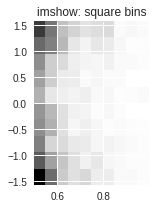

In [0]:
f = plt.figure(figsize=(7,3))
ax = f.add_subplot(131, title='imshow: square bins')
ax.hist2d(x_train[:,0],x_train[:,1])

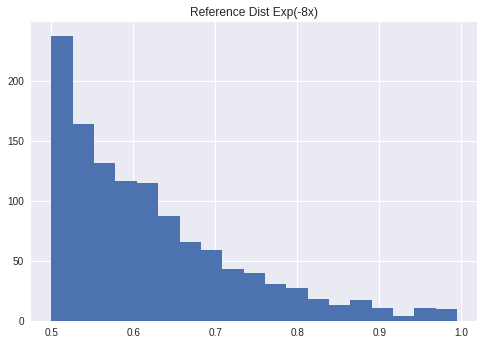

In [0]:
#Plot Histogram
#plt.hist(sm_sample, bins='auto')  # arguments are passed to np.histogram
plt.hist(x_train[:,0], bins='auto') 
plt.title("Reference Dist Exp(-8x)")
plt.show()


In [0]:
bsm_cut = []
for x in bsm_sample:
  if x >= 0.5:
    bsm_cut.append(x)

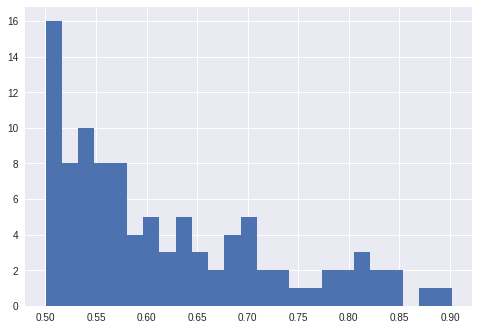

In [0]:
bsm_hist=plt.hist(bsm_sample, bins=25)  # arguments are passed to np.histogram

In [0]:
print(len(bsm_cut),len(sm_cut))

39 3602


In [0]:
sm_target_c = np.zeros(len(sm_cut))
bsm_target_c = np.ones(len(bsm_cut))

x_train_cut = np.append(sm_cut,bsm_cut)
y_train_cut = np.append(sm_target_c,bsm_target_c)

rfw = len(sm_cut)/len(bsm_cut)

### generate another sample

In [0]:
bsm_sampleT= BSM_gen.rvs(size=2000)

bsm_cutT = []
for x in bsm_sampleT:
  if x >= 0.5:
    bsm_cutT.append(x)

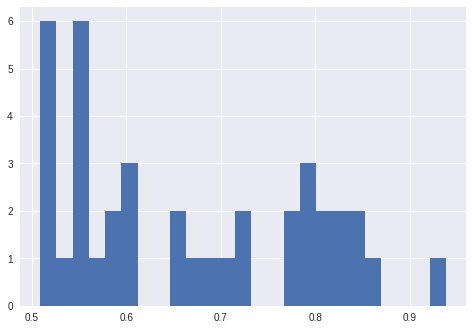

In [0]:
test_hist=plt.hist(bsm_cutT, bins=25)

In [0]:
np.savez('Samples200k_2k_R2',bsm_sample=bsm_sampleT,sm_sample=sm_sample)

In [0]:
print(os.getcwd())
print(os.listdir('/content'))

/content
['datalab', '.nv', 'tarray_all.npy', 'BsmSamples', '.rnd', 'model_5_cut_R2_5M.h5', '.cache', 'model_5_S200k_2k_R500k.h5', '.ipython', 'Samples200k_2k.npz', '.keras', 'model_5_S200k_2k_R1_3M.h5', 'model_5_cut_R1_5M.h5', 'model_5_3.h5', 'model_5_S200k_2k_R1M.h5', 'model_5_S200k_2k_R1_1M.h5', 'Samples200k_2k_R2.npz', '.local', 'model_5_3_S200k_2k_R100k.h5', '.config', 'BsmSamples1500_1000.npy', 'model_5_3_S200k_2k_R200k.h5', '.forever', 'model_5_3_S1500_1000.h5', 'model_5_S200k_2k_R1_5M.h5']


In [0]:
sm_target_c = np.zeros(len(sm_cut))
bsm_target_c = np.ones(len(bsm_cutT))

x_train_cut = np.append(sm_cut,bsm_cutT)
y_train_cut = np.append(sm_target_c,bsm_target_c)

rfw = len(sm_cut)/len(bsm_cutT)

In [0]:
#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive
#from google.colab import auth
#from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# PyDrive reference:
# https://googledrive.github.io/PyDrive/docs/build/html/index.html

# 2. Create & upload a file 
uploaded = drive.CreateFile({'title': 'Samples200k_2k_R2.npz'})
uploaded.SetContentFile('Samples200k_2k_R2.npz')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1irHGT7u8xWDZBzfAryesx0dwNI2GdcGH


## Build NN and Train

In [0]:
#define custom loss function

def customloss(yTrue,yPred):
  return yTrue*K.log(1+K.exp(-yPred))+1/rfw*(1-yTrue)*K.log(1+K.exp(yPred))

rmsprop = keras.optimizers.RMSprop()

#clipvalue=0.5

In [0]:
sgd = optimizers.SGD()

### Generate samples

In [0]:
#Data and References
NRsm=200000
Nbsm=4020
NR = 4000

Ref_sample = SM_gen.rvs(size=NRsm)
bsm_sample= BSM_gen.rvs(size=Nbsm)

#Angle distribution function
#anglesSM = np.random.uniform(low=-pi,high=pi,size=NRsm)
#anglesBSM = np.random.uniform(low=-pi,high=pi,size=Nbsm)
anglesSM = angle_gen.rvs(size=NRsm)
anglesBSM= angle_gen.rvs(size=Nbsm)

#sm_target = np.zeros(NRsm)
#bsm_target = np.ones(Nbsm)

#xmass = np.append(sm_sample,bsm_sample)
#xangle = np.append(anglesSM,anglesBSM)

#x_train = np.append(sm_sample,bsm_sample)
#x_train = np.column_stack((xmass,xangle))
#y_train = np.append(sm_target,bsm_target)

rfw = NRsm/NR

In [0]:
bsm_sample= BSM_gen.rvs(size=Nbsm)
anglesSM = angle_gen.rvs(size=NRsm)
anglesBSM= angle_gen.rvs(size=Nbsm)

#### save the generated sample

In [0]:
sfilename = 'Sample200k_4k_R1n'
#Sample200k_4k.npz
np.savez(sfilename,bsm_sample=bsm_sample,Ref_sample=Ref_sample,anglesSM=anglesSM,anglesBSM=anglesBSM)

upload_file_to_specific_folder('1SH8q5-SqxKrpBax48m8HImqqlHSHSVfN',sfilename+'.npz')

### Load saved samples

In [0]:
samples=np.load('Sample200k_4k_R12.npz');
NRsm=200000
Nbsm=4020
sm_sample = samples['sm_sample']
bsm_sample= samples['bsm_sample']

#anglesSM=samples['anglesSM'];
#anglesBSM=samples['anglesBSM'];
anglesSM = angle_gen.rvs(size=NRsm)
anglesBSM= angle_gen.rvs(size=Nbsm)

#xmass = np.append(sm_sample,bsm_sample)
#xangle = np.append(anglesSM,anglesBSM)
#sm_target = np.zeros(NRsm)
#bsm_target = np.ones(Nbsm)

#x_train = np.append(sm_sample,bsm_sample)
x_train = np.column_stack((xmass,xangle))
y_train = np.append(sm_target,bsm_target)

rfw = NRsm/Nbsm

## Binning the Ref Sample

In [0]:
#x_train_bsm = np.column_stack(bsm_sample,anglesBSM)
Nb_angle = 50
Nb_mass = 100

H2d,yedge,xedge = np.histogram2d(anglesSM,Ref_sample,bins=[np.linspace(-pi/2,pi/2,Nb_angle+1),np.linspace(0,1,Nb_mass+1)])

In [0]:
def moving_average(a, n=2) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


In [0]:
xpos = moving_average(xedge,2);

ypos = moving_average(yedge,2);

wlist = []

for xidx, xval in enumerate(xpos):
  for yidx, yval in enumerate(ypos):
    wlist.append([yval,xval,H2d[yidx][xidx]])


In [0]:
xposf=[]; yposf=[]; zposf = [] ;

for elem in wlist:
  xposf.append(elem[1])
  yposf.append(elem[0])
  zposf.append(elem[2])

Text(0.5,0,u'Z Label')

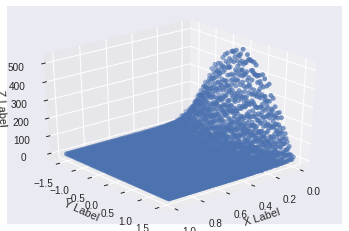

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#testarray=np.array([1,2,3,4])

ax.scatter(xposf, yposf, zposf)
ax.view_init(30,50)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
#ax.scatter(testarray,testarray,testarray, marker='o')

In [0]:
Nbins = Nb_angle*Nb_mass
xmass = np.append(xposf,bsm_sample)
xangle = np.append(yposf,anglesBSM)
#sm_target = np.zeros(NRsm)
sm_target = np.zeros(Nbins)
bsm_target = np.ones(Nbsm)

#x_train = np.append(sm_sample,bsm_sample)
x_train = np.column_stack((xmass,xangle))
y_train = np.append(sm_target,bsm_target)
weightlossa = np.append(np.asarray(zposf),bsm_target)
weightloss = K.variable(value=weightlossa.reshape((Nbsm+Nbins,1)))

#weightlossdict = dict(zip(y_train,weightloss))
#weightlossdict = {'y_train':weightloss}


#rfw = NRsm/Nbsm

In [23]:
print(x_train.shape,
y_train.shape,
      weightloss.shape)

(9020, 2) (9020,) (9020, 1)


In [0]:
fig = plt.figure(figsize=(10,15))
#ax1 = fig.add_subplot(221, projection='3d'
ax = fig.add_subplot(111)
ax.set_title('pcolormesh: exact bin edges')
X, Y = np.meshgrid(xedge, yedge)
ax.pcolormesh(X, Y, H2d)
ax.set_aspect('equal')

In [0]:
f = plt.figure(figsize=(7,7))
ax = f.add_subplot(111, title='imshow: square bins')
ax.hist2d(x_train[:,0],x_train[:,1],bins=25)

In [0]:
plt.hist(bsm_sample, bins=25)

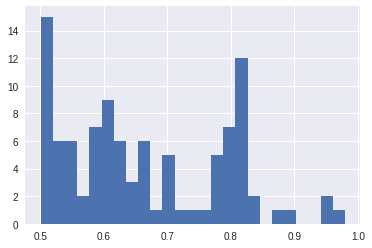

In [25]:
#Plot x distribution
sm_cut = []
for y in Ref_sample:
  if y >= gcut:
    sm_cut.append(y)


bsm_cut = []
for x in bsm_sample:
  if x >= 0.5:
    bsm_cut.append(x)
    
    
bsm_hist=plt.hist(bsm_cut, bins=25)

In [0]:
print( len(sm_cut), len(bsm_cut))

3615 83


In [0]:
#samples after the cut
Nsm_c = len(sm_cut)
Nbsm_c = len(bsm_cut)

#angles = np.random.uniform(-pi,pi,1200)
anglesSM_c = angle_gen.rvs(size=Nsm_c)
anglesBSM_c= angle_gen.rvs(size=Nbsm_c)

sm_target_c = np.zeros(Nsm_c)
bsm_target_c = np.ones(Nbsm_c)

xmass_c = np.append(sm_cut,bsm_cut)
xangle_c = np.append(anglesSM_c,anglesBSM_c)

#x_train = np.append(sm_sample,bsm_sample)
x_train_c = np.column_stack((xmass_c,xangle_c))
y_train_c = np.append(sm_target_c,bsm_target_c)

rfw_c = Nsm_c/Nbsm_c

In [0]:
f = plt.figure(figsize=(7,7))
ax = f.add_subplot(111, title='imshow: square bins')
ax.hist2d(x_train_c[:,0],x_train_c[:,1],bins=25)

### loss functions

In [0]:
#define custom loss function

def customlossML(yTrue,yPred):
  return -yTrue*yPred+1/rfw*(1-yTrue)*(K.exp(yPred)-1)

rmsprop = keras.optimizers.RMSprop()

#clipvalue=0.5

In [0]:
#Maximum likelihood loss function with binning weight
def customlossML(sw):
  #ksw = K.variable(value=sw0.reshape((len(sw0),1)))
  Nt = Nbsm+Nbins
  def lossML(yTrue,yPred):
    sw_rs = K.reshape(sw,(Nt,1))
    ytrue_rs = K.reshape(yTrue,(Nt,1))
    ypred_rs = K.reshape(yPred,(Nt,1))
    return -K.sum(ytrue_rs*sw_rs*ypred_rs)+K.sum((1-ytrue_rs)*sw_rs*(K.exp(ypred_rs)-1))/rfw
    #return (K.exp(ypred_rs)-1)
    #return K.sum(-ytrue_rs*ypred_rs*sw_rs+1/rfw*(1-ytrue_rs)*(K.exp(ypred_rs)-1)*sw_rs)
  return lossML

rmsprop = keras.optimizers.RMSprop()

In [0]:
samplefile='Samples800_100_s1'

np.savez(samplefile,xmass=xmass,xangle=xangle)



# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# PyDrive reference:
# https://googledrive.github.io/PyDrive/docs/build/html/index.html

# 2. Create & upload a file 
uploaded = drive.CreateFile({'title': samplefile+'.npz'})
uploaded.SetContentFile(samplefile+'.npz')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1gDvc_ckFfSJCiXvihZPLvsHCuHMjAyYF


## build NN

In [34]:
# build the model
model = Sequential()
#model.add(Dense(3, activation='sigmoid',input_shape=(2,), W_constraint = WeightClip(50)))
model.add(Dense(4, activation='sigmoid',input_shape=(2,),W_constraint = WeightClip(40),kernel_regularizer=keras.regularizers.l2(0.000000)))
#model.add(Dense(5, activation='sigmoid',kernel_initializer='zeros',bias_initializer='zeros',kernel_regularizer=keras.regularizers.l2(0.0001)))
#model.add(Dense(5, activation='sigmoid'))
model.add(Dense(1,W_constraint = WeightClip(40)))


# compile the model
model.compile(loss=customlossML(weightloss),
              optimizer=rmsprop)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="sigmoid", kernel_regularizer=<keras.reg..., input_shape=(2,), kernel_constraint=<__main__....)`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_constraint=<__main__....)`
  


In [0]:
model.save_weights("modelML_5_2d_init.h5")

In [0]:
model.load_weights("modelML_5_2d_init.h5")

In [0]:
upload_file_to_specific_folder('1cInKkYhUABZgHm72qidU3rE6lFca3OJP',"modelML_5_2d_init.h5")

In [0]:
'''
#Visualize network
#from keras.utils import plot_model
#plot_model(model,to_file='model.png',show_shapes='True')
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))
'''

"\n#Visualize network\n#from keras.utils import plot_model\n#plot_model(model,to_file='model.png',show_shapes='True')\nfrom IPython.display import SVG\nfrom keras.utils.vis_utils import model_to_dot\n\nSVG(model_to_dot(model).create(prog='dot', format='svg'))\n"

In [0]:
#load weight and continue training
#import h5py

#sample1
#model.load_weights("model_5_2d_R3M.h5")

#sample2
#model.load_weights("model_5_R2_R500k.h5")

#2d sample
#model.load_weights("modelML_3_2d_cut4_D1k_600_L2R5_MN0_sigmoid_500k.h5")
model.load_weights("modelML_5_2d_init.h5")

## Train NN

In [0]:
#import time
start = time.time()
print(start)

1528566659.1301281


In [0]:
#t = time.process_time()
model.fit(x_train, y_train,
          batch_size=len(x_train),
          epochs=100000,
          shuffle=False,
          verbose=0)

filename = 'modelML_3_2d_cut_3_D200k_4k_L20_WC40_sigmoid_400k.h5'
#model.save_weights(filename)




# 1. Authenticate and create the PyDrive client.
#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)

# PyDrive reference:
# https://googledrive.github.io/PyDrive/docs/build/html/index.html

# 2. Create & upload a file 
#uploaded = drive.CreateFile({'title': filename})
#uploaded.SetContentFile(filename)
#uploaded.Upload()
#print('Uploaded file with ID {}'.format(uploaded.get('id')))
#print(time.process_time() - t)

#upload_file_to_specific_folder('1cInKkYhUABZgHm72qidU3rE6lFca3OJP',filename)

In [0]:
filename = 'modelML_3_2d_cut_5_D200k_4k_L2R5E6_MW10_sigmoid_600k.h5'
model.save_weights(filename)
upload_file_to_specific_folder('1cInKkYhUABZgHm72qidU3rE6lFca3OJP',filename)



In [0]:
def t_vs_run(drun,ite):
    t_v_array=[]
    i=0;
    while i < ite:
      model.fit(x_train, y_train,
          batch_size=len(x_train),
          epochs=drun,
          shuffle=False,
          verbose=0);
      #tary = 2*(model.predict(np.column_stack((bsm_cut,anglesBSM_c)))).flatten();
      tary = -2*(model.evaluate(x=x_train,y=y_train,batch_size=len(x_train))).flatten();
      t_v_array = np.append(t_v_array,np.sum(tary));
      i +=1
      
    return t_v_array

In [38]:
#R14
#t = time.process_time()
ta = t_vs_run(10000,40)
#print(time.process_time() - t)

print(ta)

9020/9020 [==============================] - 0s 0us/step
[30.38273621 34.19232178 35.18323135 36.4687767  38.09618759 38.44382095
 39.276474   42.78272247 49.81233978 55.25823975 58.89506531 61.5598259
 62.08898163 62.39019394 62.57595444 62.70294571 62.79750443 62.87249756
 62.93447876 62.98703003 63.0326767  63.07297134 63.10890961 63.14099884
 63.17026138 63.19692993 63.2214241  63.2440834  63.26498032 63.28439713
 63.30236816 63.31945801 63.3355751  63.35067368 63.36481476 63.37815857
 63.39094925 63.40304947 63.41448212 63.42574692]


In [54]:
#R16 R2 clip 40
ta = t_vs_run(10000,20)

print(ta)

[33.92733002 33.93665314 33.93677902 33.93473053 33.94326019 33.94524384
 33.94934845 33.95293427 33.95606613 33.96080017 33.96265411 33.9667511
 33.96947098 33.97434998 33.97666931 33.97732925 33.98101807 33.98600769
 33.98844147 33.99259186]


In [0]:
ta = t_vs_run(10000,50)

print(ta)

In [0]:
for style in plt.style.available:
  print(style)

seaborn-poster
seaborn
bmh
classic
seaborn-dark-palette
fast
dark_background
seaborn-white
_classic_test
seaborn-whitegrid
seaborn-deep
seaborn-dark
seaborn-muted
seaborn-paper
seaborn-notebook
Solarize_Light2
grayscale
fivethirtyeight
seaborn-ticks
seaborn-darkgrid
seaborn-bright
seaborn-pastel
ggplot
seaborn-talk
seaborn-colorblind


Text(0.5,1,u'SM: 200k, BSM: 4020, x>0.5 ')

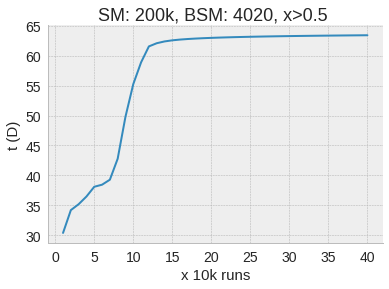

In [39]:
plt.style.use('bmh')


fig, ax = plt.subplots()
ax.plot(range(1,len(ta)+1),ta)
#ax.plot(xinput,ypred,'.')
#ax.hist(bsm_sample, bins=25)
ax.set_xlabel('x 10k runs',size=15)
ax.set_ylabel('t (D)',size=15)
ax.spines['bottom'].set_linewidth(1.)
ax.spines['left'].set_linewidth(1.)
#ax.spines['bottom'].set_visible(True)
#ax.spines['left'].set_visible(True)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    
plt.title("SM: 200k, BSM: 4020, x>0.5 ", size=18)


In [30]:
 print(os.getcwd())
dirs=os.listdir('/content')
for f in dirs:
  print(f)

/content
datalab
.cache
.ipython
.nv
.forever
.config
.keras
.local


## two branch architechture

In [0]:
#load sample

samples=np.load('Samples3k_500.npz');

In [75]:
pt_branch = Sequential()
pt_branch.add(Dense(4, activation='sigmoid',input_dim=1,W_constraint = WeightClip(40),b_constraint = WeightClip(40)))
#pt_branch.add(Dense(3, activation='sigmoid'))

angle_branch = Sequential()
angle_branch.add(Dense(4, activation='sigmoid',input_dim=1,W_constraint = WeightClip(40),b_constraint = WeightClip(40)))
#angle_branch.add(Dense(3, activation='sigmoid'))

merged = Merge([pt_branch, angle_branch], mode='concat')

model2b = Sequential()
model2b.add(merged)
model2b.add(Dense(3, activation='sigmoid',W_constraint = WeightClip(40)))
model2b.add(Dense(1,W_constraint = WeightClip(40),b_constraint = WeightClip(40)))

model2b.compile(loss=customlossML(weightloss),
              optimizer=rmsprop)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="sigmoid", input_dim=1, kernel_constraint=<__main__...., bias_constraint=<__main__....)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="sigmoid", input_dim=1, kernel_constraint=<__main__...., bias_constraint=<__main__....)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(3, activation="sigmoid", kernel_constraint=<__main__....)`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWar

In [0]:
model2b.load_weights("model2b_5_cut5_2d_R3M.h5")

In [0]:
import time
start = time.time()
print(start)

1526151810.3777657


In [76]:
t = time.process_time()
model2b.fit([xmass,xangle], y_train,
          batch_size=len(y_train),
          epochs=100000,
          shuffle=False,
          verbose=0)

filename = 'model2b_5_cut6_2d_S200_200_R100k.h5'
#model2b.save_weights(filename)
'''
#from google.colab import files
#files.download("/content/model1.json")
#files.download("/content/model_5_3_S1500_1000.h5")
#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive
#from google.colab import auth
#from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# PyDrive reference:
# https://googledrive.github.io/PyDrive/docs/build/html/index.html

# 2. Create & upload a file 
uploaded = drive.CreateFile({'title': filename})
uploaded.SetContentFile(filename)
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))
print(time.process_time() - t)
'''

'\n#from google.colab import files\n#files.download("/content/model1.json")\n#files.download("/content/model_5_3_S1500_1000.h5")\n#from pydrive.auth import GoogleAuth\n#from pydrive.drive import GoogleDrive\n#from google.colab import auth\n#from oauth2client.client import GoogleCredentials\n\n# 1. Authenticate and create the PyDrive client.\nauth.authenticate_user()\ngauth = GoogleAuth()\ngauth.credentials = GoogleCredentials.get_application_default()\ndrive = GoogleDrive(gauth)\n\n# PyDrive reference:\n# https://googledrive.github.io/PyDrive/docs/build/html/index.html\n\n# 2. Create & upload a file \nuploaded = drive.CreateFile({\'title\': filename})\nuploaded.SetContentFile(filename)\nuploaded.Upload()\nprint(\'Uploaded file with ID {}\'.format(uploaded.get(\'id\')))\nprint(time.process_time() - t)\n'

In [60]:
weightBrA = model2b.layers[0].get_weights()

print(weightBrA)

[]


In [0]:
print(os.getcwd())
print(os.listdir('/content'))

/content
['datalab', 'model_5_2d_R550k.h5', '.config', 'model_5_cut5_inti0_2d_R6M.h5', '.local', 'model_5_cut5_2d_R2M.h5', 'model_5_3_2d_R1M.h5', '.keras', '.forever', 'model_5_2d_D3_1p5k_R2000k.h5', '.rnd', '.cache', 'model2b_5_cut5_2d_R2M.h5', 'model_5_2d_D2_1k_R500k.h5', 'model_5_2d_D3_1p5k_R3000k.h5', 'model_5_2d_R1550k.h5', 'model_5_2d_R1050k.h5', 'model_5_2d_R3M.h5', '.ipython', 'Samples3k_500.npz']


In [0]:
#load weight and continue training
model2b.load_weights('model2b_5_2d_R200k.h5')

# Save and Continue training

In [0]:
#load weight and continue training
model.load_weights("model_5_3.h5")

In [0]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=2000,
          verbose=0)

In [0]:
#Save weight
model_json = model.to_json()
with open("model1.json","w") as json_file:
  json_file.write(model_json)

In [0]:
#Save weight to HDF5
model.save_weights("model2.h5")
print("Save model to disk")

Save model to disk


In [0]:
print(os.getcwd())
print(os.listdir('/content'))

/content
['datalab', '.forever', 'model_5_InitZero_2d_R4M_sagl.h5', 'model_5_2d_R1050k.h5', '.cache', 'model2b_5_2d_R200k.h5', '.config', 'model2b_5_2d_R1M.h5', 'model_5_3_2d_R1M.h5', 'model_5_2d_R3M.h5', '.nv', '.keras', '.rnd', 'model2b_5_cut_2d_R1M.h5', 'model_5_2d_R550k.h5', 'model_5_2d_R1550k.h5', '.local', '.ipython']


In [0]:
#download weight
from google.colab import files
files.download("/content/model1.json")
files.download("/content/model1.h5")

In [0]:
#upload saved data
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Export NN function and Plot Result

In [0]:
def BSM2d(x,y):
  return BSMn(x)*(1*cos(y))

def SM2d(x,y):
  return SMn(x)*(1*cos(y))

def BSM2d_c(x,y,cutv):
  norm1 = integrate.quad(lambda a :BSMn(a),cutv,1)
  return BSMn(x)/norm1[0]*anglen(y)

def SM2d_c(x,y,cutv):
  norm2 = integrate.quad(lambda a :SMn(a),cutv,1)
  return SMn(x)/norm2[0]*anglen(y)

In [0]:
model.load_weights("modelML_3_2d_cut_5_D200k_4k_L2R5E6_MW10_sigmoid_600k.h5")

In [0]:
x = np.arange(0.5,1,0.01)
#y = np.arange(-pi,pi,0.01)
y = np.arange(-pi/2,pi/2,0.025)

tseq = []
for j in y:
  for i in x:
    tseq = np.append(tseq,exp(model.predict(np.asarray([[i,j]])))*SM2d_c(i,j,0.5))
    #tseq = np.append(tseq,exp(model2b.predict([np.asarray([[i]]),np.asarray([[j]])]))*SM2d_c(i,j,0.5))
    
    
    
tseqr = np.reshape(tseq,(len(y),len(x)))

###print weight

In [46]:
weightL1 = model.layers[0].get_weights()

print(weightL1)

[array([[  0.30089578,  -0.09148896,   0.09149009,  -0.30089572],
       [-40.        ,  40.        , -40.        ,  40.        ]],
      dtype=float32), array([-65.18095, -65.13434,  65.13434,  65.18095], dtype=float32)]


In [0]:
weightL2 = model.layers[1].get_weights()

print(weightL2)

[array([[ 85.26478 ],
       [-48.157024],
       [-44.555298]], dtype=float32), array([20.561792], dtype=float32)]


In [0]:
weightL3 = model.layers[2].get_weights()

print(weightL3)

Text(0.5,0.98,u'SM: 200k, BSM: 4020, 600k Rounds \n Arch: 1 layer 3 neurons, sigmoid activation, L2 regul.=5E-6')

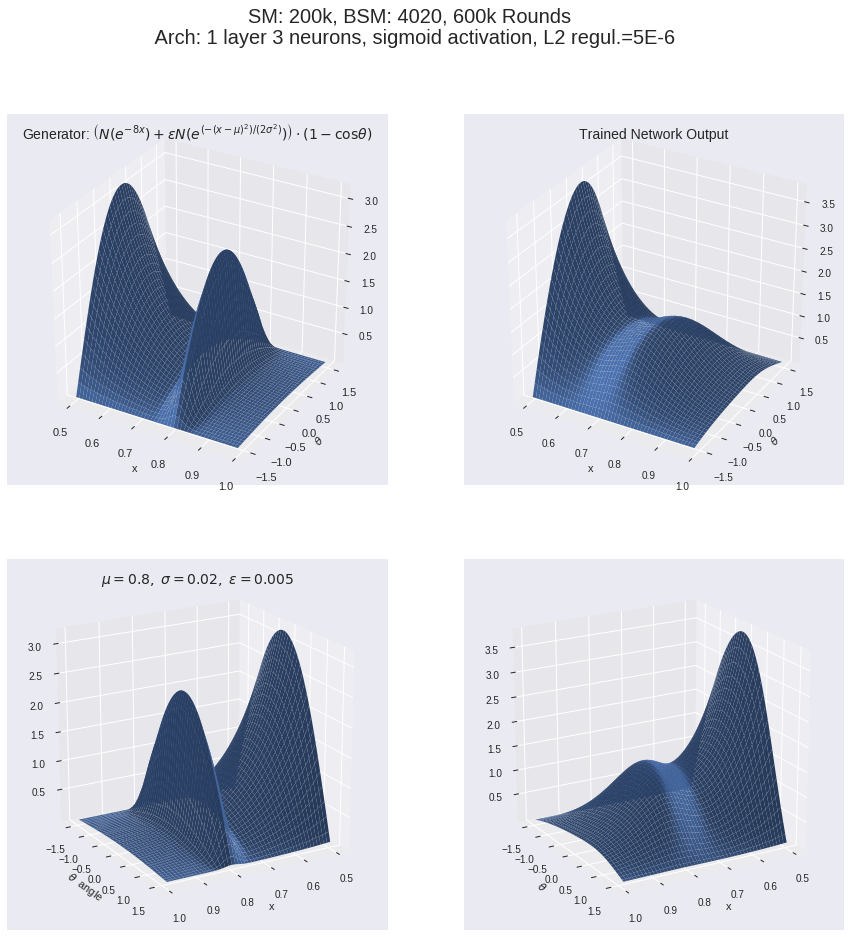

In [32]:
#hfont = {'fontname':'Helvetica'}

fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(221, projection='3d')

#x = np.arange(0.5,1,0.01)
#y = np.arange(-pi,pi,0.01)

#xx, yy = np.meshgrid(x,y, sparse = True)
xx,yy = np.meshgrid(x,y, sparse = True)

#BSM2d(r)
z=np.vectorize(BSM2d_c)(xx,yy,0.5)

ax1.plot_surface(xx,yy,z)
ax1.set_xlabel('x')
ax1.set_ylabel(r'$\theta$')
#ax1.zscale('log', nonposy='clip')
plt.title(r'Generator: $\left( N(e^{-8x})+\epsilon N(e^{(-(x-\mu)^2)/(2 \sigma^2)}) \right) \cdot (1-\cos \theta) $',fontsize=14)
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(11)
    
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(11)


ax2 = fig.add_subplot(222, projection = '3d')
ax2.plot_surface(xx,yy,tseqr)
ax2.set_xlabel('x')
ax2.set_ylabel(r'$\theta$')
plt.title("Trained Network Output",fontsize=14)

ax3 = fig.add_subplot(223, projection = '3d')
ax3.plot_surface(xx,yy,z)
ax3.set_xlabel('x')
ax3.set_ylabel(r'$\theta \;\;$' 'angle')
ax3.view_init(20,60)
plt.title(r'$\mu=0.8,\;\sigma=0.02,\;\epsilon =0.005$',fontsize=14)

ax4 = fig.add_subplot(224, projection = '3d')
ax4.plot_surface(xx,yy,tseqr)
ax4.set_xlabel('x')
ax4.set_ylabel(r'$\theta$')
ax4.view_init(20,60)
#plt.title("Arch: 1 layer 3 neurons, sigmoid activation, L2 regul.=5E-6",fontsize=14)

plt.suptitle("SM: 200k, BSM: 4020, 600k Rounds \n Arch: 1 layer 3 neurons, sigmoid activation, L2 regul.=5E-6", fontsize=20)

In [0]:

plotfilename = 'NN_3N_cut5_D200k_4020_L2_5E6_WC10_sigmoid_600k.pdf'

fig.savefig(plotfilename)

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#plotfile = '2d_train_7_2d_cut5_D4k_1k_clipv5_R5000k.pdf'
# PyDrive reference:
# https://googledrive.github.io/PyDrive/docs/build/html/index.html

# 2. Create & upload a file 
#uploaded = drive.CreateFile({'title': plotfilename})
#uploaded.SetContentFile(plotfilename)
#uploaded.Upload()
#print('Uploaded file with ID {}'.format(uploaded.get('id')))

upload_file_to_specific_folder('1cInKkYhUABZgHm72qidU3rE6lFca3OJP',plotfilename)


In [0]:
tary = 2*(model.predict(np.column_stack((bsm_cut,anglesBSM_c)))).flatten()

In [0]:
np.sum(tary)

38.820946

Text(0.5,1,'SM: 1k, BSM: 100, Sample 1, 1M Rounds')

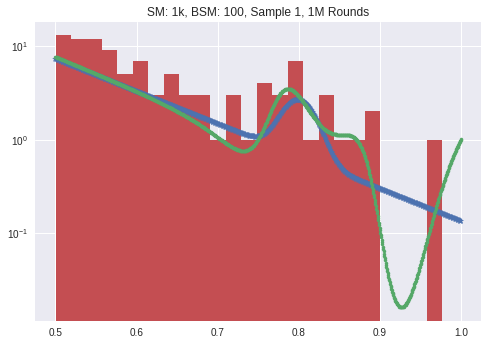

In [0]:
fig, ax = plt.subplots()
ax.plot(xinput,yorig,'*')
ax.plot(xinput,ypred,'.')
ax.hist(bsm_sample, bins=25)
plt.yscale('log', nonposy='clip')
plt.title("SM: 1k, BSM: 100, Sample 1, 1M Rounds")

In [0]:
#compare NN output and generating function
xinput_all = np.linspace(0.,1,1000)
y=[]
for xi in xinput_all:
  #y.append(exp(NNfunction2(xi,weightL1,weightL2)[0][0])*SMn(xi))
  #y.append(exp(NNfunction(xi,weightL1,weightL2)[0][0]))
  y.append(BSMn(xi))
  
  
ypred_all = np.vectorize(exp)(model.predict(xinput_all));
ypred_all = ypred_all.flatten()*np.vectorize(SMn)(xinput_all);

## Compute test statistics

In [0]:
#Likelihood Ratio Test
tlist = []
for xii in bsm_sample:
  tlist.append(NNfunction2(xii,weightL1,weightL2)[0][0])
  
print(np.sum(tlist))


tarray = 2*(model.predict(bsm_sample)).flatten();
print(np.sum(tarray))

57.732620310031955
115.46521


In [0]:
#distribution of t
Nsmb = 4000;
rfw_tc = len(sm_cut)/Nsmb;

def customlossMLc(yTrue,yPred):
  return -yTrue*yPred+1/rfw_tc*(1-yTrue)*(K.exp(yPred)-1)

class test_statistics:
  '''
  Compute test statistics given data sample(bsm or sm) 
  '''
  def __init__(self,NNmodel,lossfunc,RefSample,TrainSample):
    self.NNmodel = NNmodel
    self.lossfunc = lossfunc
    self.RefSample = RefSample
    self.sm_sample_t = SMc_gen.rvs(size=Nsmb)
    self.anglesSM_t = angle_gen.rvs(size=Nsmb)
    
  #train NN with data(input) sample and ref sample
  #training variables
  
  #generate sm sample
  
  def train_t(self,epoch,lossfunc):
    self.sm_sample_t = SMc_gen.rvs(size=Nsmb)
    self.anglesSM_t = angle_gen.rvs(size=Nsmb)
    bsm_target_tc = np.ones(Nsmb)
    xmass_t = np.append(sm_cut,self.sm_sample_t)
    xangle_t = np.append(anglesSM_c,self.anglesSM_t)
    
    #bsm_target_t = np.ones(Nbsm_c)

    x_train_t = np.column_stack((xmass_t,xangle_t))
    y_train_t = np.append(sm_target_c,bsm_target_tc)
    self.NNmodel.compile(loss=lossfunc,optimizer=rmsprop)
    #self.NNmodel.load_weights("modelML_5_2d_init.h5")
    self.NNmodel.fit(x_train_t, y_train_t,
          batch_size=len(x_train_t),
          epochs=epoch,
          verbose=0);
    tary = 2*(self.NNmodel.predict(np.column_stack((self.sm_sample_t,self.anglesSM_t)))).flatten();
    return (np.sum(tary))
    
  def train_result(self,cutv):
    x = np.arange(cutv,1,0.01)
    y = np.arange(-pi/2,pi/2,0.025)

    tseq = []
    for j in y:
      for i in x:
        tseq = np.append(tseq,exp(model.predict(np.asarray([[i,j]])))*SM2d_c(i,j,cutv))
    
    tseqr = np.reshape(tseq,(len(y),len(x)))
    #fig, ax = plt.subplots(projection='3d')
    
    fig1 = plt.figure(figsize=(7,7))
    xx,yy = np.meshgrid(x,y, sparse = True)
    ax = fig1.add_subplot(111, projection = '3d')
    ax.plot_surface(xx,yy,tseqr)
    ax.set_xlabel('x')
    ax.set_ylabel(r'$\theta$')
    plt.title("SM: 2k, BSM: 200, Sample 1, 1.2M Rounds",fontsize=14)
    plt.show()
    
    
  def t_vs_run(self,drun,ite):
    xmass_t = np.append(sm_cut,self.sm_sample_t)
    xangle_t = np.append(anglesSM_c,self.anglesSM_t)
    bsm_target_tc = np.ones(Nsmb)
    x_train_t = np.column_stack((xmass_t,xangle_t))
    y_train_t = np.append(sm_target_c,bsm_target_tc)
    self.NNmodel.compile(loss=self.lossfunc,optimizer=rmsprop)
    
    t_v_array=[]
    i=0;
    while i < ite:
      self.NNmodel.fit(x_train_t, y_train_t,
          batch_size=len(x_train_t),
          epochs=drun,
          verbose=0);
      tary = 2*(self.NNmodel.predict(np.column_stack((self.sm_sample_t,self.anglesSM_t)))).flatten();
      t_v_array = np.append(t_v_array,np.sum(tary));
      i +=1
      
    return t_v_array
  
  def t_value(self):
    tary = 2*(self.NNmodel.predict(np.column_stack((sm_sample_t,anglesSM_t)))).flatten();
    return (np.sum(tary)) 

In [0]:
len(anglesSM_c)

3570

In [0]:
len(sm_cut)

3570

In [0]:
smtrain1 = test_statistics(model,customlossMLc)

In [0]:
tarray = smtrain1.t_vs_run(10000,100)

In [0]:
print(tarray)

[13.5667057  15.4197464  15.43516159 15.46499252 15.50199699 15.53859901
 15.5662365  15.58906937 15.60687065 15.61881256 15.62802124 15.63319588
 15.63680649 15.63751793 15.63661003 15.63501167 15.63181114 15.62725639
 15.62272453 15.62101746 15.61838913 15.61815834 15.62403297 15.63528824
 15.65713882 15.68634605 15.7238884  15.76880646 15.81741905 15.86499786
 15.91081429 15.95276833 15.99255943 16.02810097 16.06109428 16.09018135
 16.11697006 16.14027214 16.16258621 16.18297005 16.20026207 16.21577072
 16.23001862 16.24406052 16.2570343  16.26825333 16.27809906 16.28751945
 16.29654694 16.30467415 16.31273842 16.31972504 16.32669258 16.3334446
 16.33959389 16.34538651 16.35076904 16.35575104 16.36068153 16.36572456
 16.36982727 16.37369537 16.37780952 16.38110161 16.38574409 16.38879585
 16.39197731 16.39480972 16.39842415 16.40115738 16.40424919 16.40736198
 16.40990448 16.41313744 16.41607285 16.41881371 16.42137146 16.42398071
 16.42674446 16.42874718 16.43194771 16.43434143 16.

In [0]:
fig, ax = plt.subplots(figsize = (8,6))
#fig1 = plt.figure(facecolor='white')
#ax = plt.axes(frameon=True)
#ax.set_facecolor('white')
ax.plot(range(1,len(tarray)+1),tarray)
#ax.plot(xinput,ypred,'.')
#ax.hist(bsm_sample, bins=25)
ax.axis('auto')
#ax.set_anchor((0,0))
ax.grid(True)
ax.set_xlabel('x 10k runs',size=15)
ax.set_ylabel('t (R)',size=15)
#ax.spines['bottom'].set_linewidth(1)
#ax.spines['left'].set_linewidth(1)
#ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
#plt.yscale('log', nonposy='clip')
#plt.xticks(range(1,10,10),range(1,10,10))
ax.set_title("SM: 200k, BSM: 4020, x>0.5",size=18)
plt.subplots_adjust(bottom=0.15)


for label in ax.get_ticklabels():
  label.set_rotation(45)
  label.set_fontsize(16)

#ax.draw()

In [0]:
tarray10k50R1=np.array([6.51207161  7.2483387   7.71594048  8.07175255  8.3565979   8.59105492
  8.7889576   8.95766449  9.10435104  9.2323494   9.34585571  9.44564629
  9.53365326  9.61269951  9.68392372  9.74649429  9.8041153   9.85485649
  9.90026665  9.94205093  9.9802475  10.01398277 10.04444122 10.07260323
 10.09846115 10.12013817 10.14096451 10.16246414 10.17786789 10.19262123
 10.20655823 10.22085571 10.23260307 10.24283028 10.25219917 10.26178169
 10.26958847 10.27536583 10.28084564 10.28681183 10.29360199 10.29886055
 10.30295563 10.30595207 10.30957222 10.31306839 10.31357193 10.3149128
 10.31832123 10.31690598])

In [0]:
len(tarray)

72

In [0]:
smtrain1.train_t(20000,customlossML)

796.0928

In [0]:
smtrain1.train_result(0.5)

In [0]:
def get_tsm(Nsample):
  tvalue_array = []
  smtrain = test_statistics(model,customlossMLc)
  i=0
  while i < Nsample:
    tvalue_array.append(smtrain.train_t(200000,customlossMLc))
    #tvalue_array.append(smtrain.t_value())
    i += 1
    
  return tvalue_array

In [0]:
t = time.process_time()
tarray2 = get_tsm(10)
print(tarray2)
print(time.process_time() - t)

[11.9573555, 7.1428375, 15.580963, 11.086571, 12.127045, 8.163109, 35.205555, 4.7552986, 4.13097, 21.240387]
13391.958654189999


In [0]:
t = time.process_time()
tarray2 = get_tsm(25)
print(tarray2)
print(time.process_time() - t)

[12.448734, 8.343151, 2.999569, 11.258251, 10.019241, 4.69812, 14.007263, 0.9439087, -1.7368622, -0.45786285, 1.764965, 3.4663277, 2.0784607, 7.968746, 12.509335, 12.732555, 11.15712, 8.878368, 10.126976, 3.58535, 8.5193405, 4.748558, 12.377155, 4.23851, 2.246849]
33114.005030198


In [0]:
tary200kR2cut=np.array([6.280324, 3.935751,3.002756, 3.428236, 6.76935, 7.586645, 21.619804, 4.3351784, 9.306698, 9.7299, 19.548218, 5.6026573,
                       14.930061, 9.929951, 4.20903, 2.857113, 8.879791, 18.498081, 10.508842, 5.499588, 5.8298645, 1.9355392,27.536953, 11.842777,
                        9.680717, 6.4893913, 6.888027,11.9573555, 7.1428375, 15.580963, 11.086571, 12.127045, 8.163109, 35.205555, 4.7552986, 4.13097, 
                        21.240387,12.448734, 8.343151, 2.999569, 11.258251, 10.019241, 4.69812, 14.007263, 0.9439087, -1.7368622, -0.45786285, 1.764965,
                        3.4663277, 2.0784607, 7.968746, 12.509335, 12.732555, 11.15712, 8.878368, 10.126976, 3.58535, 8.5193405, 4.748558, 12.377155, 4.23851, 2.246849])

In [0]:
tary200kR1cut=np.array([9.198353, 22.413506, 18.658892, 3.3231735, 12.6468315, 19.533606, 7.0150704, 7.973974, 15.004824,
                       1.8119359, 17.662802, 9.209027, 8.491543, 6.6254063, 7.361366, 20.885723, 2.8854532, 15.239798, 12.919951,
                       15.254736, 49.6819, 6.9491396, 9.390984, 8.531012, 5.195326, 7.3243885, 10.206685, 13.672317, 10.485491,
                       11.436906, 13.185726, 10.5280075, 13.9951, 10.375193, 23.16745, 7.866772, 9.366356, 15.060921, 24.468105,
                       2.1078587, 12.849054, 7.8117046, 1.1931639, 9.656768, 8.3884945, 10.9362335, 19.04181, 5.602028, 6.96894,
                       13.527407, 9.009592, 9.232324, 13.798014, 26.165163, 17.853573, 5.0918174, 0.0597561, 4.3211384, 
                       16.246407, 15.064257, 11.282628, 5.164405, 17.900526, 10.412801, 12.343819, 18.298119, 4.579193, 6.9842525,
                       2.6973543, 9.363689, 8.552435, 11.587778, 16.519943,16.553617, 12.130791, 4.799429, 5.813991, 25.142912, 
                       10.338545, 22.89791, 16.821117, 6.818872, 13.331888,14.899183, 6.5405235, 17.230661, 4.3786163, 16.537035, 7.003011, 
                       21.634886, 6.693706, 2.0629637, 17.045473,10.030758, 10.766983, 8.218758, 4.9844117, 9.099534, 12.161718, 18.165085, 
                       14.922871, 9.762325, 17.848711,11.368221, 13.5494585, 10.52153, 10.173314, 15.988689, 8.45729, 11.216583, 9.845869, 10.222246, 13.011869])

In [0]:
tary200kAll=np.array([9.198353, 22.413506, 18.658892, 3.3231735, 12.6468315, 19.533606, 7.0150704, 7.973974, 15.004824,
                       1.8119359, 17.662802, 9.209027, 8.491543, 6.6254063, 7.361366, 20.885723, 2.8854532, 15.239798, 12.919951,
                       15.254736, 49.6819, 6.9491396, 9.390984, 8.531012, 5.195326, 7.3243885, 10.206685, 13.672317, 10.485491,
                       11.436906, 13.185726, 10.5280075, 13.9951, 10.375193, 23.16745, 7.866772, 9.366356, 15.060921, 24.468105,
                       2.1078587, 12.849054, 7.8117046, 1.1931639, 9.656768, 8.3884945, 10.9362335, 19.04181, 5.602028, 6.96894,
                       13.527407, 9.009592, 9.232324, 13.798014, 26.165163, 17.853573, 5.0918174, 0.0597561, 4.3211384, 
                       16.246407, 15.064257, 11.282628, 5.164405, 17.900526, 10.412801, 12.343819, 18.298119, 4.579193, 6.9842525,
                       2.6973543, 9.363689, 8.552435, 11.587778, 16.519943,16.553617, 12.130791, 4.799429, 5.813991, 25.142912, 
                       10.338545, 22.89791, 16.821117, 6.818872, 13.331888,14.899183, 6.5405235, 17.230661, 4.3786163, 16.537035, 7.003011, 
                       21.634886, 6.693706, 2.0629637, 17.045473,10.030758, 10.766983, 8.218758, 4.9844117, 9.099534, 12.161718, 18.165085, 
                       14.922871, 9.762325, 17.848711,11.368221, 13.5494585, 10.52153, 10.173314, 15.988689, 8.45729, 11.216583, 9.845869, 10.222246, 13.011869,
                     6.280324, 3.935751,3.002756, 3.428236, 6.76935, 7.586645, 21.619804, 4.3351784, 9.306698, 9.7299, 19.548218, 5.6026573,
                       14.930061, 9.929951, 4.20903, 2.857113, 8.879791, 18.498081, 10.508842, 5.499588, 5.8298645, 1.9355392,27.536953, 11.842777,
                        9.680717, 6.4893913, 6.888027,11.9573555, 7.1428375, 15.580963, 11.086571, 12.127045, 8.163109, 35.205555, 4.7552986, 4.13097, 
                        21.240387,12.448734, 8.343151, 2.999569, 11.258251, 10.019241, 4.69812, 14.007263, 0.9439087, -1.7368622, -0.45786285, 1.764965,
                        3.4663277, 2.0784607, 7.968746, 12.509335, 12.732555, 11.15712, 8.878368, 10.126976, 3.58535, 8.5193405, 4.748558, 12.377155, 4.23851, 2.246849])

In [0]:
t = time.process_time()
tarray2 = get_tsm(10)
print(tarray2)
print(time.process_time() - t)

In [0]:
tarray50kR1=np.array([17.859928, 21.576794, 22.648262, 4.7346706, 0.041297942,9.307671, 7.986084, 2.9581623, 11.567207, 7.4215584,19.745886, 3.8535743, 7.994503, 11.461901, 19.316307,18.834127, 10.514814, 9.93902, 21.024137, 6.800843,13.896572, 7.2651596, 15.426065, 14.872274, 34.841877])

In [0]:
tarrayR1 = np.array([13.871891, 9.872658, 20.530746, 12.656269,12.109566, 16.218359, 5.0516987])

(array([0.00666794, 0.03333969, 0.05334351, 0.06445674, 0.07556997,
        0.0577888 , 0.03111705, 0.03111705, 0.01111323, 0.01111323,
        0.00666794, 0.00222265, 0.        , 0.        , 0.00222265,
        0.        , 0.        , 0.        , 0.        , 0.00222265]),
 array([-1.7368622 ,  0.83407591,  3.40501402,  5.97595213,  8.54689024,
        11.11782835, 13.68876646, 16.25970457, 18.83064268, 21.40158079,
        23.9725189 , 26.54345701, 29.11439512, 31.68533323, 34.25627134,
        36.82720945, 39.39814756, 41.96908567, 44.54002378, 47.11096189,
        49.6819    ]),
 <a list of 20 Patch objects>)

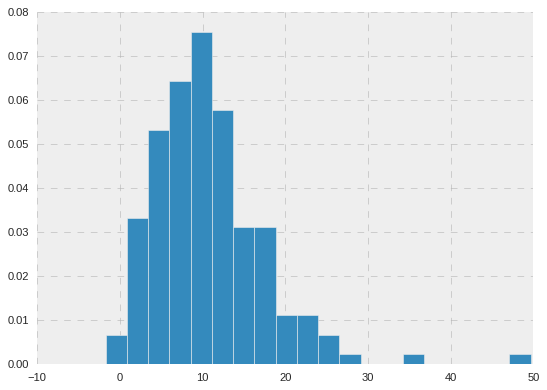

In [0]:
plt.hist(tary200kAll, bins=20,normed=True)

In [0]:
np.save('tarray1',tarray1)

In [0]:
print(os.getcwd())
print(os.listdir('/content'))

/content
['datalab', 'Sample200k_4k.npz', '.local', 'Samples800_100_s1.npz', 'modelML_3_2d_cut_5_D200k_4k_L2R5E6_MW10_sigmoid_600k.h5', '.rnd', '.forever', '.config', 'modelML_5_2d_init.h5', '.ipython', '2d_NN_3_2d_cut5_D200k_4020_L25E6_WC0_sigmoid_600k.pdf', '.keras', '.cache']


In [0]:
#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive
#from google.colab import auth
#from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# PyDrive reference:
# https://googledrive.github.io/PyDrive/docs/build/html/index.html

# 2. Create & upload a file 
uploaded = drive.CreateFile({'title': 'tarray_all.npy'})
uploaded.SetContentString('all t-value array')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))


Uploaded file with ID 177bawBU7H5SRoDp-OSpHfS8IxBiwNxcw
